## Bag of Words Classification

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import keras
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [3]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [4]:
data = pd.read_csv('cleaned_short_simple.csv')

In [5]:
any(data.comment_text.isnull())

True

In [6]:
data.comment_text = data.comment_text.replace(np.nan, '')

In [7]:
x = data.comment_text
y = data.y

In [10]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)

# Balance train set
x_balance, y_balance = RandomOverSampler().fit_sample(pd.DataFrame(x_train), y_train)

x_balance = x_balance.tolist()
x_balance = [x for [x] in x_balance]
x_balance = pd.DataFrame(x_balance)

x_balance = x_balance[0]

### Try using TF-IDF instead of Count Vectorizer

In [11]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english', binary=True)
x_train_tfidf1 = tfidf1.fit_transform(x_balance)
x_test_tfidf1  = tfidf1.transform(x_test)

In [12]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
x_train_tfidf2 = tfidf2.fit_transform(x_balance)
x_test_tfidf2  = tfidf2.transform(x_test)

In [13]:
probabilities_tdidf = {}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


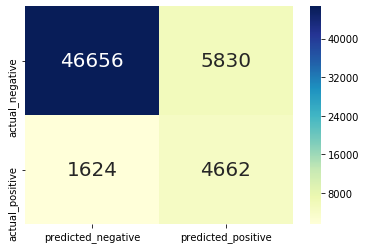

In [15]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# Fit the first logistic regression on the TF-IDF data
lr.fit(x_train_tfidf1, y_balance)
y_pred_tfidf1_lr = lr.predict(x_test_tfidf1)
lr_prob = lr.predict_proba(x_test_tfidf1)
probabilities_tdidf['log_reg'] = lr_prob
cm1 = conf_matrix(y_test, y_pred_tfidf1_lr)

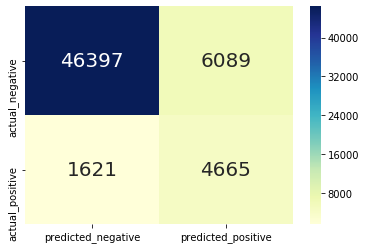

In [16]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(x_train_tfidf2, y_balance)
y_pred_tfidf2_lr = lr.predict(x_test_tfidf2)

lr_prob = lr.predict_proba(x_test_tfidf2)
probabilities_tdidf['log_reg_bi'] = lr_prob
cm2 = conf_matrix(y_test, y_pred_tfidf2_lr)

In [17]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train_tfidf1, y_balance)
y_pred_cv1_nb = bnb.predict(x_test_tfidf1)
y_prob_cv1 = bnb.predict_proba(x_test_tfidf1)
probabilities_tdidf['BernoulliNB'] = y_prob_cv1

In [18]:
bnb = BernoulliNB()
bnb.fit(x_train_tfidf2, y_balance)
y_pred_cv2_nb = bnb.predict(x_test_tfidf2)
y_prob_cv2 = bnb.predict_proba(x_test_tfidf2)
probabilities_tdidf['BernoulliNB_bigram'] = y_prob_cv2

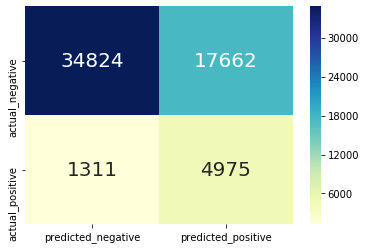

In [19]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

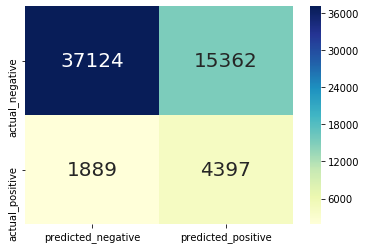

In [20]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [21]:
model = XGBClassifier()
model.fit(x_train_tfidf1, y_balance)
predict = model.predict(x_test_tfidf1)
xgb_proba = model.predict_proba(x_test_tfidf1)
probabilities_tdidf['XGB'] = xgb_proba

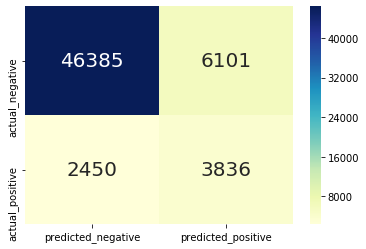

In [22]:
cm5 = conf_matrix(y_test, predict)

In [23]:
model = XGBClassifier()
model.fit(x_train_tfidf2, y_balance)
predict = model.predict(x_test_tfidf2)
xgb_proba2 = model.predict_proba(x_test_tfidf2)
probabilities_tdidf['XGB_bigram'] = xgb_proba2

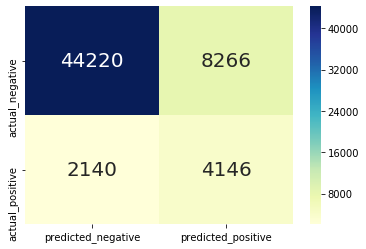

In [24]:
cm6 = conf_matrix(y_test, predict)

In [25]:
import keras

In [35]:
deep_model = keras.Sequential([
    keras.layers.Dense(units=30, input_shape=(92719, ), name="hidden_layer"),
    keras.layers.Activation("relu", name="1_activation"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, name="hidden_layer2"),
    keras.layers.Activation("relu", name="2_activation"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=1, name="output_layer"),
    keras.layers.Activation("sigmoid", name="sigmoid_activation"),   
])
deep_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [36]:
deep_model.fit(x_train_tfidf1, y_balance, epochs=3)

Epoch 1/3
314918/314918 [==============================] - 138s 437us/step - loss: 0.3133 - binary_accuracy: 0.8726
Epoch 2/3
314918/314918 [==============================] - 158s 503us/step - loss: 0.1676 - binary_accuracy: 0.9399
Epoch 3/3
314918/314918 [==============================] - 158s 503us/step - loss: 0.1149 - binary_accuracy: 0.9612


In [37]:
pred_nn = deep_model.predict(x_test_tfidf1)

In [38]:
pred_nn_probs = deep_model.predict_proba(x_test_tfidf1)

In [39]:
probabilities_tdidf['NN_2layers'] = pred_nn_probs

In [40]:
pred_nn_ = np.where(pred_nn >= 0.005, 1, 0)

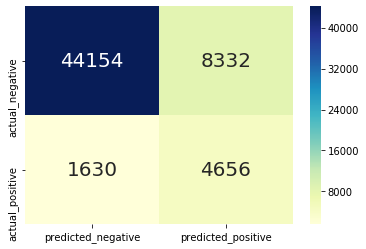

In [41]:
cm7 = conf_matrix(y_test, pred_nn_)

In [42]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6, cm7)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg', 'LogReg_bi', 'NB-Ber', 'NB-Ber-bi', 'XGB1', 'XGB2', 'NN_2layers']
results_nb

,LogReg,LogReg_bi,NB-Ber,NB-Ber-bi,XGB1,XGB2,NN_2layers
Accuracy,0.873,0.869,0.677,0.706,0.855,0.823,0.830
Precision,0.444,0.434,0.220,0.223,0.386,0.334,0.358
Recall,0.742,0.742,0.791,0.699,0.610,0.660,0.741
F1 Score,0.556,0.548,0.344,0.338,0.473,0.444,0.483


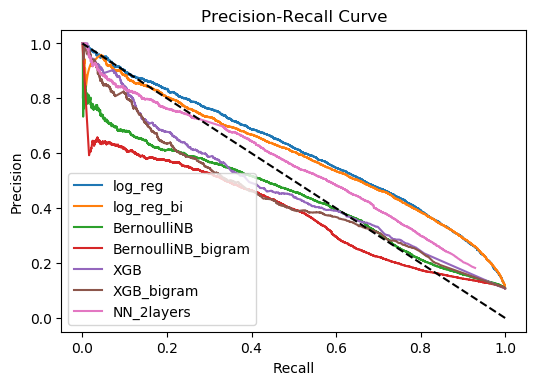

In [43]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
plt.figure(dpi=100)
for model, prob in probabilities_tdidf.items():
    if model == 'NN_2layers':
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob)
    else:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob[:, 1])
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.legend(probabilities_tdidf.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
plt.plot([1, 0], [0, 1], c='black', ls='--')

# TDIDF

In [47]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4, cm5, cm6)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['LogReg1', 'LogReg2', 'NB1-Multi', 'NB2-Multi', 'NB1-Ber', 'NB2-Ber']
results_nb

,LogReg1,LogReg2,NB1-Multi,NB2-Multi,NB1-Ber,NB2-Ber
Accuracy,0.873,0.869,0.750,0.738,0.674,0.701
Precision,0.444,0.434,0.267,0.259,0.218,0.220
Recall,0.738,0.743,0.762,0.783,0.796,0.706
F1 Score,0.554,0.548,0.395,0.389,0.342,0.335


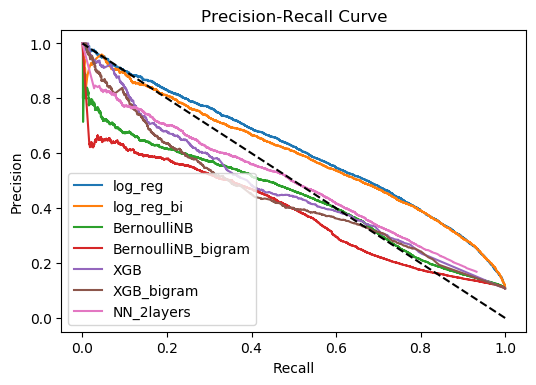

In [142]:
plt.figure(dpi=100)
for model, prob in probabilities_tdidf.items():
    if model == 'NN_2layers':
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob)
    else:
        precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, prob[:, 1])
    plt.plot(recall_curve[1:], precision_curve[1:], label='precision')
    plt.legend(probabilities_tdidf.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
plt.plot([1, 0], [0, 1], c='black', ls='--')